In [1]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
import torchvision.transforms.functional as fn

d:\Anaconda\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes = ('bird','cat','bird and cat')
two_classes = ('bird','cat')

In [3]:
#single test
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("cat_test (3).jpeg")).unsqueeze(0).to(device)
text = clip.tokenize(["bird","cat","bird and cat"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  


Label probs: [[0.001778 0.04807  0.95    ]]


In [4]:

test_path = './test'
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_data = datasets.ImageFolder(root=test_path, transform=transformations)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16,
                                         num_workers = 0)

In [5]:
# image, class_id = next(iter(test_loader))
# image_input = image.to(device)
# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

# # Calculate features
# with torch.no_grad():
#     image_features = model.encode_image(image_input)
#     text_features = model.encode_text(text_inputs)
# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# values, indices = similarity[0].topk(3)

# # Print the result
# print("\nTop predictions:\n")
# for value, index in zip(values, indices):
#     print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")

In [6]:
def test(classes,test_loader):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    y_test = []
    y_pred = []
    for data, target in test_loader:
        image_input = data.to(device)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in two_classes]).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1).to("cpu")
        _,pred = torch.max(similarity,1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        pred = pred.data.numpy()
        target = target.data.numpy()
        y_pred.append(pred.flatten()[:])
        y_test.append(target.flatten()[:])
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    y_test = np.concatenate(y_test)
    y_pred = np.concatenate(y_pred)
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    return y_test,y_pred

In [7]:
test_classes =['bird','cat']
y_test,y_pred=test(test_classes,test_loader)

Test Accuracy of  bird: 98% (81/82)
Test Accuracy of   cat: 98% (244/248)


In [8]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.985837922895358

Text(0.5, 0, 'False Positive Rate')

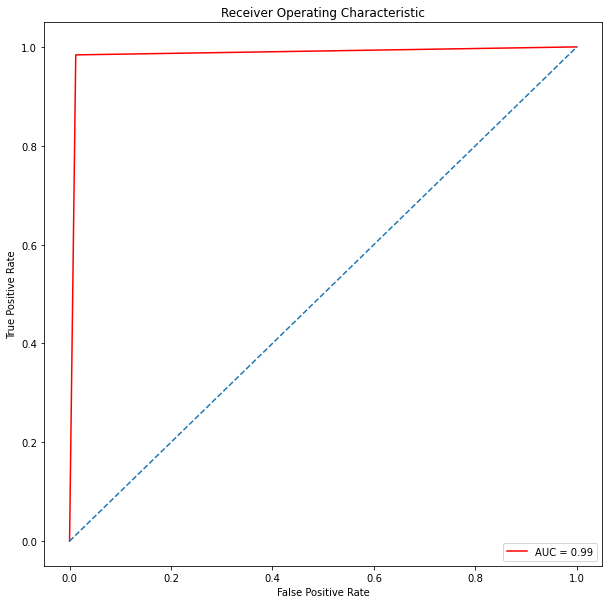

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')